In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
#plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
# import catboost as catb
# import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import calc_pot_temp

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [4]:
df_ERA_raw = pd.read_csv("data/MeteorologicalData/ERAI_data.csv.gz", parse_dates=["date"])

In [5]:
df_ERA = df_ERA_raw.copy()

# Load CESM data 

In [6]:
df_CESMp = pd.read_csv("data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMp_features = set(df_CESMp.columns)

In [7]:
df_CESMf = pd.read_csv("data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMf_features = set(df_CESMf.columns)

In [8]:
# Calculate and append the stability parameters
df_CESMp = calculate_stability(df = df_CESMp, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_CESMf = calculate_stability(df = df_CESMf, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Pressure lvl doesnt exist (700-900 hPa, 4382, 250)
Pressure lvl doesnt exist (850-900 hPa, 4382, 250)
Pressure lvl doesnt exist (700-900 hPa, 4382, 375)
Pressure lvl doesnt exist (850-900 hPa, 4382, 375)
Pressure lvl doesnt exist (700-900 hPa, 4382, 500)
Pressure lvl doesnt exist (850-900 hPa, 4382, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 250)
Pressure lvl doesnt exist (850-900 hPa, 4476, 250)
Pressure lvl doesnt exist (700-900 hPa, 4476, 375)
Pressure lvl doesnt exist (850-900 hPa, 4476, 375)
Pressure lvl doesnt exist (700-900 hPa, 4476, 500)
Pressure lvl doesnt exist (850-900 hPa, 4476, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 625)
Pressure lvl doesnt exist (850-900 hPa, 4476, 625)
Pressure lvl doesnt exist (700-900 hPa, 4476, 750)
Pressure lvl doesnt exist (850-900 

# Use only features which are also in CESM and which are not in the Alps

In [9]:
# Only allow features which also exist in CESM
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
df_ERA = df_ERA[intersecting_features]

In [10]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [11]:
df_ERA

,V_4947_375_700,U_4382_1250_700,V_4476_1500_500,U_4853_1375_500,SLP_4287_1375_sealevel,SLP_4947_375_sealevel,V_4570_375_850,Z_4947_375_500,U_4287_250_500,T_4853_1375_500,...,V_4287_750_700,Z_4287_1500_700,Z_4287_1125_700,U_4853_1125_700,V_4382_125_850,V_4853_125_500,T_4759_125_900,V_4476_1250_500,U_4853_750_850,Z_4382_250_850
0,-8.778254,-1.949725,-12.080680,6.074563,1002.307373,1013.034302,-5.028343,5346.677734,22.202852,-35.617214,...,-8.577211,2771.997314,2865.590820,11.424900,-1.146921,-16.085457,-1.368560,-13.048079,11.922429,1441.265381
1,-5.969459,6.595381,-15.106171,4.169692,1006.319641,1011.824036,-1.439861,5334.997559,21.233097,-36.231441,...,-5.228330,2838.875977,2882.494385,12.056975,-0.258394,-15.058628,-2.172589,-17.861540,9.751382,1402.756226
2,-7.172423,9.040929,-13.881407,8.926577,1008.062195,1011.895081,-2.484225,5324.791016,19.499496,-35.856552,...,-6.662611,2875.718018,2893.721191,9.898549,-8.805115,-14.496703,-2.371656,-16.837437,8.510113,1405.742554
3,-9.801356,8.455927,-10.893802,11.962904,1007.607483,1012.361206,-5.339229,5308.489746,16.282488,-36.779865,...,-9.883936,2885.203369,2889.862061,9.748493,-8.743429,-14.535955,-2.136600,-9.775720,7.582114,1415.590576
4,-10.778939,7.538810,-4.128820,11.427619,1006.972961,1014.443176,-5.652349,5296.888184,27.662922,-38.135056,...,-11.948767,2881.810303,2880.795410,10.759873,-9.843168,-17.803823,-4.384941,-5.584256,6.676454,1408.092163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57947,2.228271,0.337566,-1.044113,-3.131036,1016.648926,1019.896667,-2.678375,5850.551758,-0.929989,-11.522769,...,2.834808,3194.435547,3194.779541,-1.892978,-3.329445,-2.111422,22.021383,-3.146672,-2.403204,1566.512207
57948,7.171435,-1.341656,1.529859,-2.758779,1016.616760,1018.915710,2.293048,5841.269531,1.278540,-11.690927,...,5.708480,3187.621582,3186.119385,-3.454876,1.690555,-1.913230,20.969135,-0.290249,-4.592199,1558.928589
57949,5.805546,-4.724221,0.828513,-2.974693,1015.655273,1015.289551,4.169058,5818.098633,0.777219,-11.889299,...,0.070062,3184.231201,3176.795166,-0.746076,1.456576,1.017483,20.575178,0.740484,-1.895120,1547.610962
57950,6.758009,-0.180292,2.388351,-0.065320,1014.718567,1011.410828,3.076540,5799.322754,-0.617119,-11.372659,...,1.046752,3172.230225,3163.762451,0.709535,0.770189,11.030643,18.989172,3.255139,2.722509,1545.667725


# Calculate derived variables

In [12]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

#df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)
df_pressures = pd.DataFrame(SLP_dict)

del SLP_dict

In [13]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

#df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)
df_Z = pd.DataFrame(Z_dict)

del df_Z_level, Z_dict

In [14]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

#df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)
df_PHIT = pd.DataFrame(PHIT_dict)

del df_T, PHIT_dict

In [15]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [16]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [17]:
df_ERA = pd.concat([df_ERA["date"], 
                     df_pressures, 
                     df_Z, 
                     df_PHIT, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Merge in foehn data at specified location

In [18]:
location="ALT"
df_foehn_raw = pd.read_csv(f"data/FoehnData/{location}_foehn.csv", parse_dates=["date"])
df_foehn_raw.dropna(inplace=True, how="any", axis=0)

# Merge ERAI and foehn data
df_ERA_all_features = pd.merge(df_foehn_raw, df_ERA, on="date", how="inner")

# Drop rows with missing foehn  values
# df_ERA_all_features.dropna(inplace=True, how="any", axis=0)
# df_ERA_all_features.reset_index(inplace=True, drop=True)

# Train Model on full data

In [19]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [20]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [21]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

In [22]:
# model_cat = catb.CatBoostClassifier(loss_function='Logloss',
#                                 verbose=True,
#                                 scale_pos_weight=20,
#                                 thread_count=20,
#                                 max_depth=4, 
#                                 learning_rate=0.1, 
#                                 n_estimators=1000,
#                                 reg_lambda=10,
#                                    random_state=42)

# df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

[15:17:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:17:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:17:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[15:17:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:17:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:17:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[15:17:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[15:17:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[15:17:51] INFO: /workspace/src/tree/upd

[15:20:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[15:20:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:20:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[15:20:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[15:20:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[15:20:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[15:20:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[15:20:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:20:59] INFO: /workspace/src/tree/upd

[15:23:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[15:23:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:23:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:23:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:23:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:24:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:24:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:24:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[15:24:08] INFO: /workspace/src/tree/upd

,feature_name,importance
0,diff_Z_4570_1375_850_Z_4664_375_850,0.150541
1,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,0.119735
2,diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,0.048149
3,diff_Z_4476_1500_850_Z_4476_500_850,0.029323
4,diff_Z_4476_1500_850_Z_4476_625_850,0.028387
5,diff_PHIT_4476_875_850_PHIT_4853_1125_850,0.023545
6,diff_SLP_4476_1250_sealevel_SLP_4853_875_sealevel,0.021990
7,diff_Z_4570_1375_850_Z_4570_375_850,0.021809
8,diff_SLP_4664_1375_sealevel_SLP_4853_1000_seal...,0.015027
9,diff_Z_4287_500_850_Z_4476_1375_850,0.012941


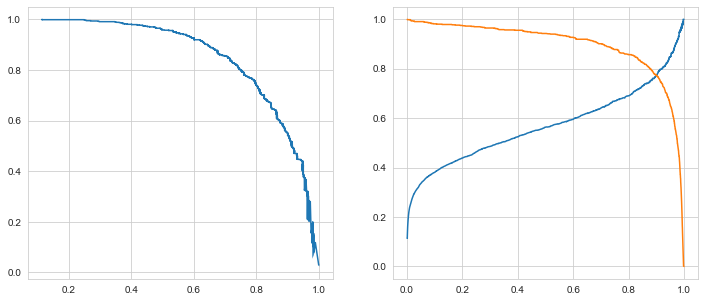

In [23]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=200,
                    verbosity=2,
                    nthread=30,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg, df_ERA_all_features, feature_names)

In [303]:
df_ERA_feature_importances.loc[50:100, :]

,feature_name,importance
50,diff_Z_4287_375_850_Z_4476_500_850,0.002884
51,diff_Z_4853_1000_850_Z_4853_1500_850,0.002807
52,DELTAPHI_4947_750_700,0.002705
53,diff_Z_4853_1250_850_Z_4853_1500_850,0.002680
54,diff_Z_4287_375_850_Z_4947_1000_850,0.002658
55,diff_Z_4287_125_850_Z_4853_1375_850,0.002577
56,diff_PHIT_4570_1375_850_PHIT_4853_1000_850,0.002315
57,diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,0.002286
58,diff_PHIT_4382_625_850_PHIT_4853_1125_850,0.002179
59,diff_Z_4476_1375_850_Z_4853_750_850,0.002175


# Reduce dataframe to most important features

In [213]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:200, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [214]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [215]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

In [216]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [217]:
# def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
#     plt.figure(figsize=(16,9))
#     plt.plot(MONTH_NAMES, precision_scores)
#     plt.plot(MONTH_NAMES, recall_scores)
#     plt.plot(MONTH_NAMES, f1_scores)
#     plt.legend(["precision", "recall", "f1-score"])

In [218]:
# def get_best_model_through_CV(model, parameters_CV):
#     # Fit model
#     model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
#     model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
#                  df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
#     print(model_CV.best_params_)
    
#     # Predict and optimize threshold
#     best_model = model_CV.best_estimator_
#     df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
#                                                              df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
#     best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#     df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
#     # Plot model evaluation curves
# #     f = plt.figure(figsize=(12,5))
# #     f.add_subplot(121)
# #     sns.lineplot(precisions, recalls)
# #     f.add_subplot(122)
# #     sns.lineplot(np.append(thresholds, 1.0), precisions)
# #     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
#     # Print model evaluation scores
    
#     df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
#     print(f"Best threshold: {best_threshold_ERA}")
#     print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
#     display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
#     precision_scores, recall_scores, f1_scores = [], [], []
#     for month in range(1,12+1):
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)

#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
#     return best_model, best_threshold_ERA

In [219]:
# from sklearn.model_selection import cross_validate

# def train_model_for_each_month(model, parameters):
#     models_retrained_list, thresholds_list = [], []
    
#     precision_scores, recall_scores, f1_scores = [], [], []
    
#     plt.figure(figsize=(16,9))
#     for month in range(1,12+1):
#         # Define train and test masks
#         train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
#         # CV
# #         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
# #         print(model.get_params())
#         model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
#         model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
#                      df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
#         print(model_CV.cv_results_["mean_test_score"])
#         # Get feature importance
# #         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
#         # Optimize threshold
#         best_model = model_CV.best_estimator_
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
#         precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
#                                                                  df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
#         best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
#         # Print model evaluation scores
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)
        
#         print(f"Best threshold: {best_threshold_ERA}")
#         print(f'Precision: {precision}')
#         print(f'Recall: {recall}')
#         print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
#         display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
#         # Retrain model on full data
#         best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
#                        df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
#         models_retrained_list.append(best_model)
#         thresholds_list.append(best_threshold_ERA)
        
#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
#     return models_retrained_list, thresholds_list

In [266]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=5000):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

# def custom_metric_for_month(estimator, X, y):
#     month_mask_ERA_custom_metric = (df_ERA_reduced_features_scaled["date"].dt.month == month)
#     month_mask_CESMp_custom_metric = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
    
#     prediction_probas_ERA = estimator.predict_proba(X)[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(y, prediction_probas_ERA)
#     best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]                                                         
    
#     foehn_truth = df_ERA_reduced_features_scaled.loc[month_mask_ERA_custom_metric, "Foehn"]
#     CESMp_predictions = (estimator.predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp_custom_metric, feature_names_reduced]) >best_threshold_ERA).astype(int)
    
    
    
    
#     return -np.square(np.mean(CESMp_predictions)-np.mean(foehn_truth))

In [305]:
params = {'max_depth': 4, 'learning_rate': 0.2, "reg_alpha":1, "reg_lambda":10, "n_jobs": 25,"verbosity":1, "seed": 0}

models_retrained_list, thresholds_list = [], []
precision_scores, recall_scores, f1_scores= [], [], []

most_important_features = dict()


# Train first on all data
D_train = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced],
                      label=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"], 
                      weight=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"]*20+1)
model_ges = xgb.Booster(params, [D_train])
model_ges = xgb.train(params, dtrain = D_train, num_boost_round=10, xgb_model=model_ges)

print("Done Fitting on whole Dataset")

total_confusion_matrix= np.zeros((2,2))

for month in range(1,12+1):
    print(MONTH_NAMES[month-1])
    
    # Define masks to address specific parts of data set
    # ERA masks
    train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_ERA = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)

    # Build training dataset from ERA and CESMp
    df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                              df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                            axis=0)
    
    
    D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced], label=df_ERA_CESMp["Foehn"], weight=(df_ERA_CESMp["Foehn"]*20+1))
    
    # Train model
    #model = xgb.Booster(params, [D_train])
    model = model_ges.copy()
    for _ in range(100):
        pred = model.predict(D_train)
        g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
        model.boost(D_train, g, h)
    
    
    # Make prediction on whole data
    D_total = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[month_mask_ERA, feature_names_reduced])
    yhat = sigmoid(model.predict(D_total))
    
    
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"] = yhat
    
    # Calculate metrics on test set & identify best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))-1]
    thresholds_list.append(best_threshold_ERA)
    
    # Make final prediciton for ERA
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction"] = (df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"]>best_threshold_ERA).astype(int)

    # Print model evaluation scores
    precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1score)
    total_confusion_matrix += confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])


    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
    
    importances_month = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False)
    #display(importances_month.head(10))
    
    
    for row in importances_month.head(30).iterrows():
        if row[0] in most_important_features.keys():
            most_important_features[row[0]] += row[1][0]
        else:
            most_important_features[row[0]] = row[1][0]
    
    models_retrained_list.append(model)

Done Fitting on whole Dataset
Jan
Best threshold: 0.4078996479511261
Precision: 0.6615384615384615
Recall: 0.6615384615384615
[[1142   22]
 [  22   43]]
Feb
Best threshold: 0.1825697422027588
Precision: 0.8333333333333334
Recall: 0.8333333333333334
[[1060   10]
 [  10   50]]
Mar
Best threshold: 0.3994077742099762
Precision: 0.7241379310344828
Recall: 0.7241379310344828
[[1158   16]
 [  16   42]]
Apr
Best threshold: 0.47250616550445557
Precision: 0.8478260869565217
Recall: 0.8478260869565217
[[1037   21]
 [  21  117]]
May
Best threshold: 0.43090754747390747
Precision: 0.7090909090909091
Recall: 0.7090909090909091
[[1092   32]
 [  32   78]]
Jun
Best threshold: 0.4414139688014984
Precision: 0.7
Recall: 0.7
[[1145   12]
 [  12   28]]
Jul
Best threshold: 0.4670027494430542
Precision: 0.5714285714285714
Recall: 0.5714285714285714
[[1206    6]
 [   6    8]]
Aug
Best threshold: 0.09906342625617981
Precision: 0.6956521739130435
Recall: 0.6956521739130435
[[1209    7]
 [   7   16]]
Sep
Best thre

In [307]:
def save_figure(name):
    plt.savefig(f'/home/chmony/Documents/Results/newgradient/{name}.pdf', bbox_inches='tight', dpi=200)
    print(f'Saved figure at: /home/chmony/Documents/Results/newgradient/{name}.pdf')
    
foehn_type={"ALT": "SouthFoehn", "LUG": "NorthFoehn"}

[[13574.   192.]
 [  192.   578.]]
Precision: 0.7506493506493507
Recall: 0.7506493506493507
Saved figure at: /home/chmony/Documents/Results/newgradient/statistical_test_ERAI_CESMp_SouthFoehn.pdf


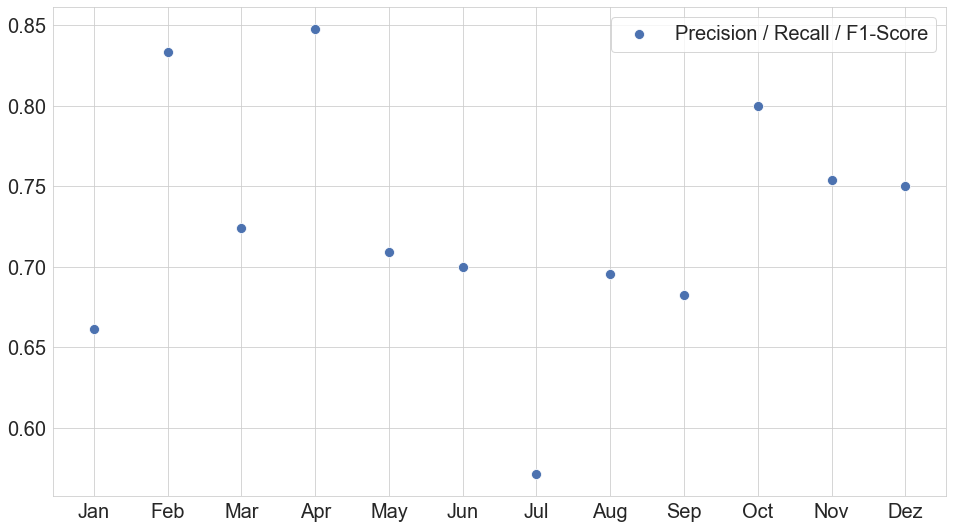

In [308]:
plt.rcParams.update({'font.size': 20})

print(total_confusion_matrix)
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, np.array(precision_scores), s=100, alpha=1, marker="o")
# sns.scatterplot(MONTH_NAMES, np.array(recall_scores)-0.002, s=100, alpha=1)
# sns.scatterplot(MONTH_NAMES, np.array(f1_scores), s=100, alpha=1)
plt.legend(["Precision / Recall / F1-Score"])

save_figure(f"statistical_test_ERAI_CESMp_{foehn_type[location]}")

[[13574.   192.]
 [  192.   578.]]
Precision: 0.7506493506493507
Recall: 0.7506493506493507


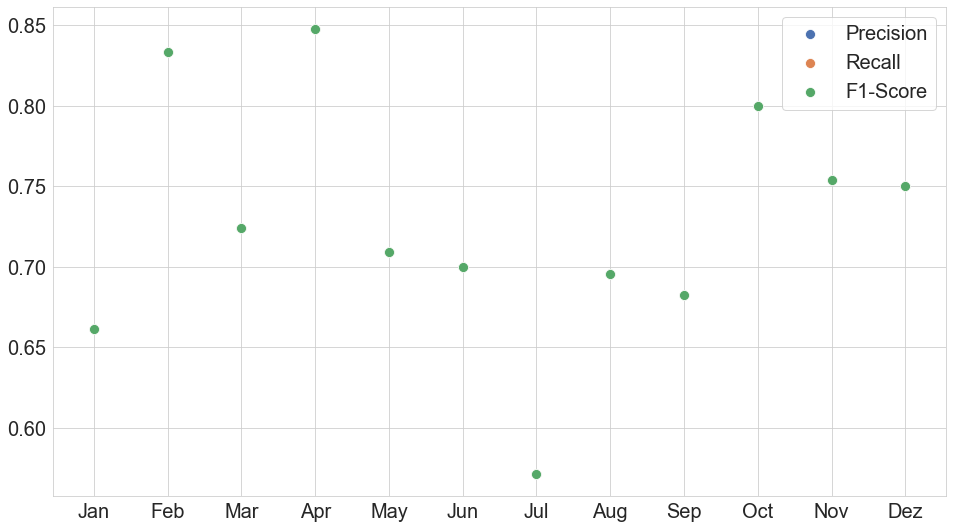

In [270]:
print(total_confusion_matrix)
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, precision_scores, s=100)
sns.scatterplot(MONTH_NAMES, recall_scores, s=100)
sns.scatterplot(MONTH_NAMES, f1_scores, s=100)
plt.legend(["Precision", "Recall", "F1-Score"])

# Predict on CESMp and CESMf

In [271]:
for month in range(1,12+1):
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
    month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )

    xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
    df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
    df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)

    xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
    df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
    df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [272]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [273]:
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

In [274]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMp_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMf_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]]], 
                                     axis=0, 
                                     ignore_index=True)

In [275]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [276]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [277]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [278]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

Saved figure at: /home/chmony/Documents/Results/newgradient/final_comparison_SouthFoehn.pdf


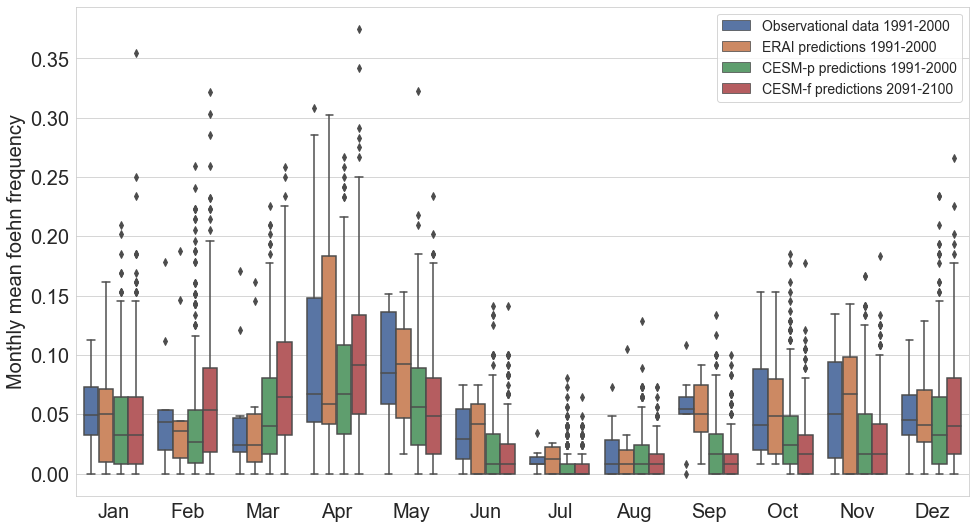

In [279]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")

handles, labels = fig.get_legend_handles_labels()
labels = ["Observational data 1991-2000", "ERAI predictions 1991-2000", "CESM-p predictions 1991-2000", "CESM-f predictions 2091-2100" ]
fig.legend(handles, labels, fontsize=14)
save_figure(f"final_comparison_{foehn_type[location]}")

# Second statistical test

Saved figure at: /home/chmony/Documents/Results/newgradient/statistical_test_ERAI_CESMp_SouthFoehn.pdf


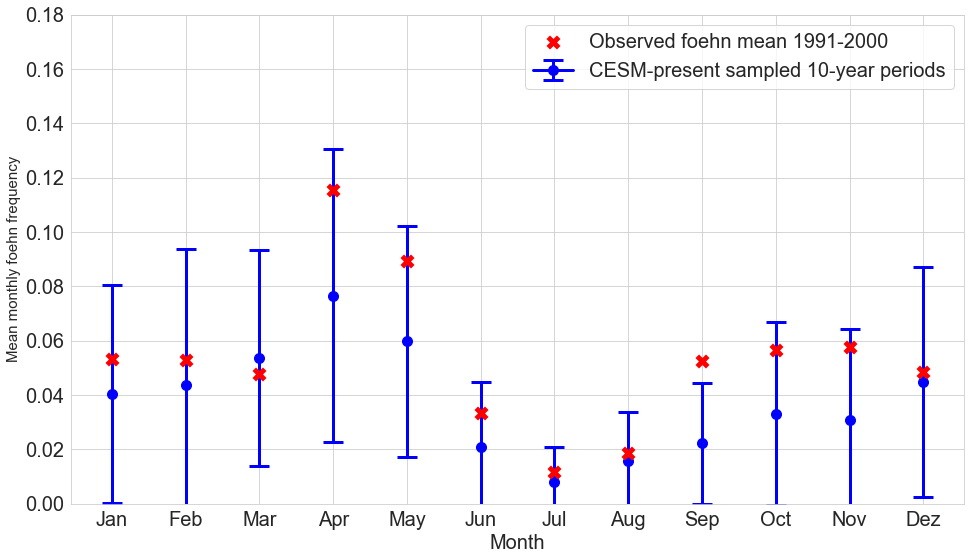

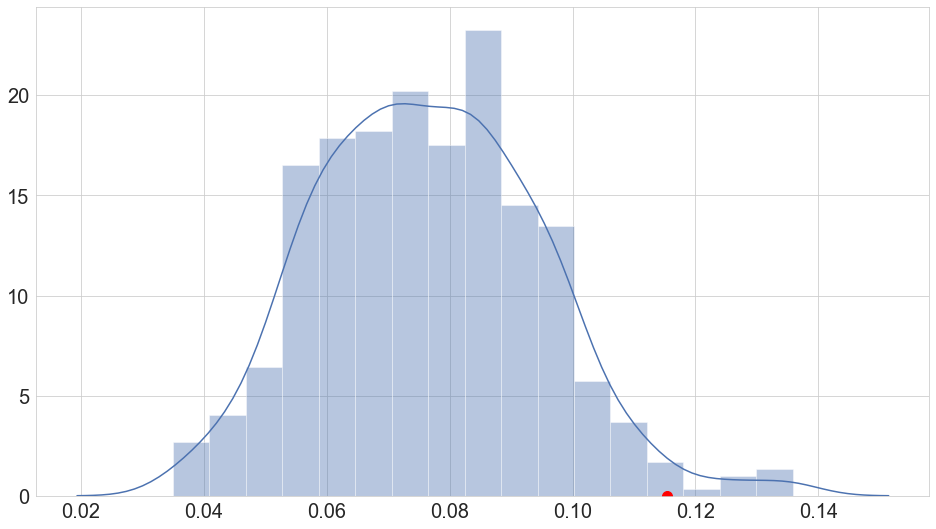

In [286]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["Observed foehn mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.18))

save_figure(f"statistical_test_ERAI_CESMp_{foehn_type[location]}")



# Third statistical test

In [281]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.4944	False
Feb	0.0	True
Mar	0.0	True
Apr	0.00156	True
May	0.15287	False
Jun	0.06034	False
Jul	0.00787	True
Aug	0.00274	True
Sep	5e-05	True
Oct	0.00018	True
Nov	0.4944	False
Dez	0.2489	False


# Ensemble deviation

Saved figure at: /home/chmony/Documents/Results/newgradient/final_comparison_ensembles_SouthFoehn.pdf


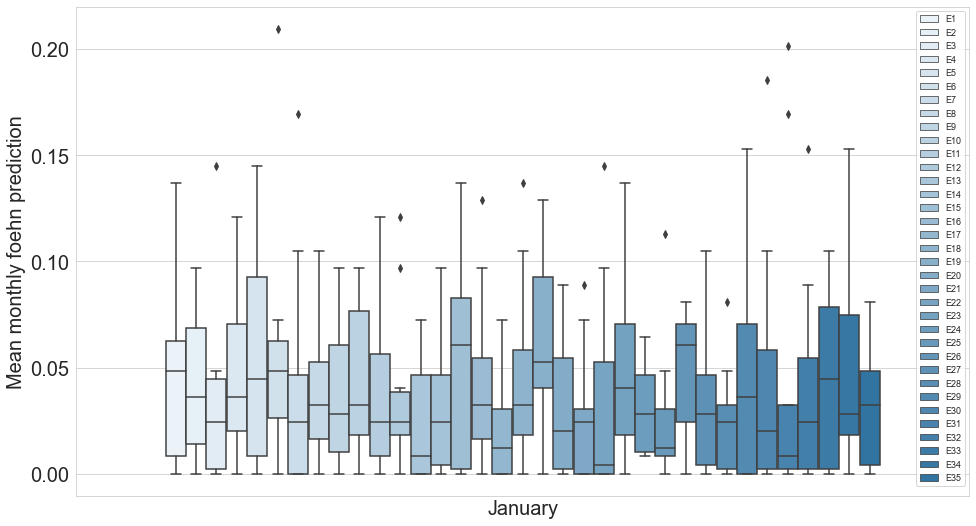

In [282]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January")
ax.set_ylabel("Mean monthly foehn prediction")
ax.legend(fontsize=9)

save_figure(f"final_comparison_ensembles_{foehn_type[location]}")

# Plot weathermaps

In [283]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")

In [321]:
variable ='DELTAPHI'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "$^\circ$K",
        "DELTAPHI": "$^\circ$K",
        "U": "m/s",
        "V": "m/s"}


# # Altdorf
v_limits = {"SLP": [1003, 1018],
            "Z": [1350, 1520],
            "T": [5+273.15, 9+273.15],
            "DELTAPHI": [6,11],
            "U":[5,15],
            "V":[5,15]}

# # Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

# Lugano
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}


df_importances = generate_coordinates_from_feature_label(most_important_features, variable)
df_importances["importance"] = df_importances["importance"]

In [322]:
df_importances

,variable,lat1,lon1,importance
0,DELTAPHI,4853,1000,339.557448
1,DELTAPHI,4853,1000,433.513452
2,DELTAPHI,4853,875,132.206791
3,DELTAPHI,4476,1000,155.978537
4,DELTAPHI,4947,1125,256.589421


Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_OBS_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_ERA-Interim_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_CESM-present_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_CESM-future_SouthFoehn.pdf'


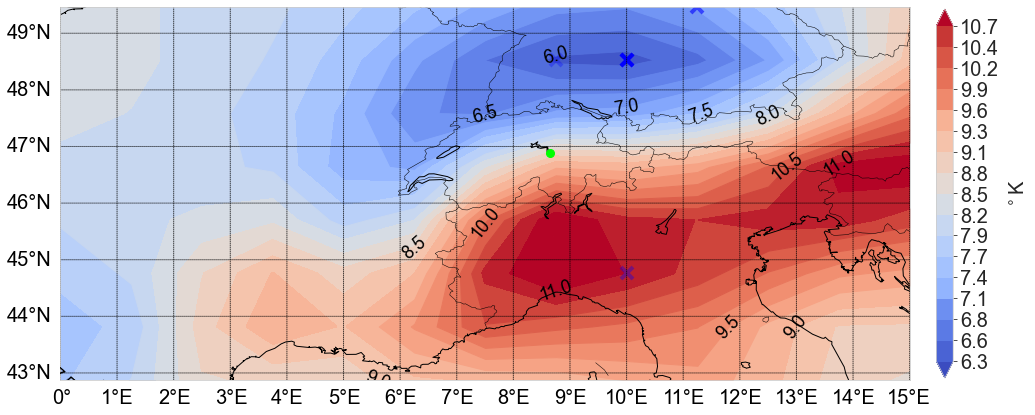

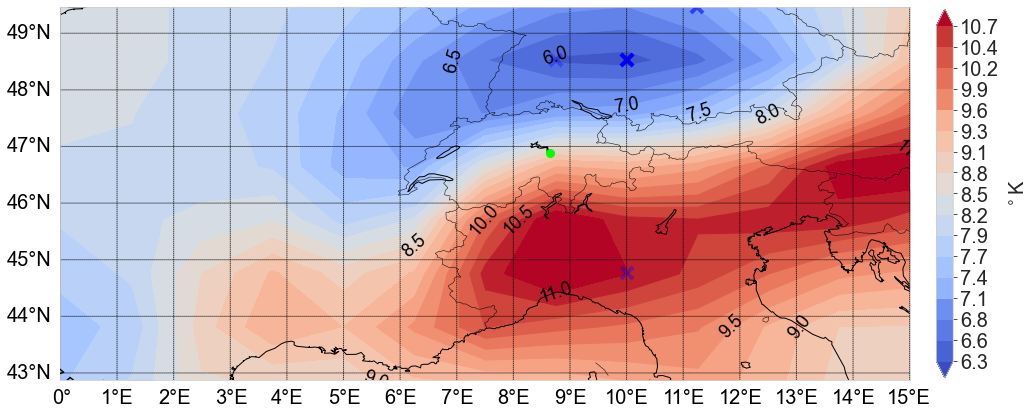

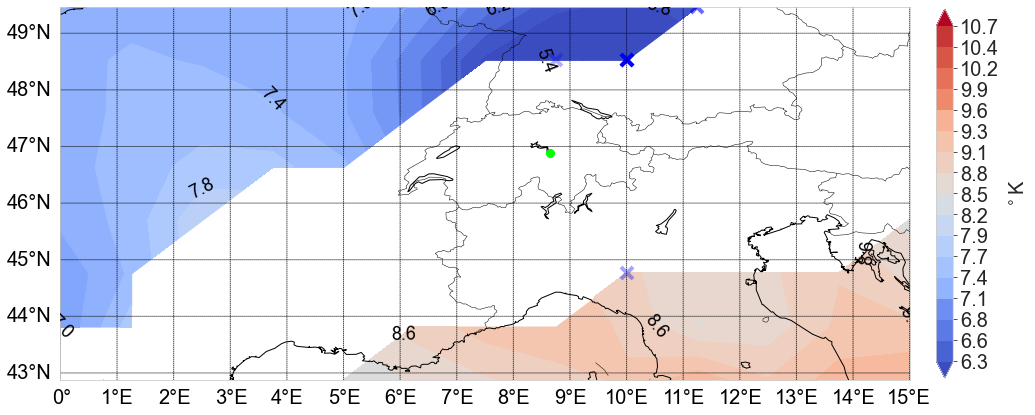

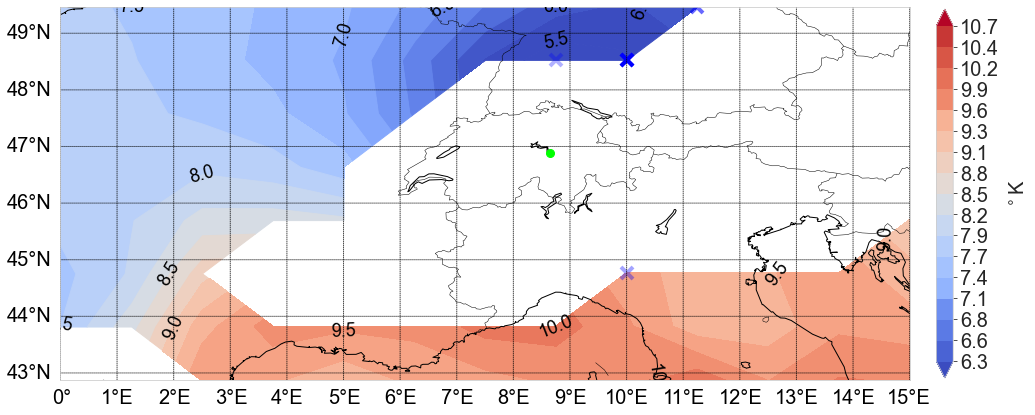

In [323]:
kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": df_importances}


month = 4
month_mask_ERA = df_ERA_with_stability["date"].dt.month == month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_with_stability.loc[:, "Foehn"], 
                                        )

plot_mean_foehn_condition_for_one_model(**kwargs,
                                        model= f"ERA-Interim_{foehn_type[location]}",
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[:, "prediction"], 
                                        )

month_mask_CESMp = df_CESMp["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"CESM-present_{foehn_type[location]}", 
                                        df = df_CESMp.loc[:,:], 
                                        foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                        )
month_mask_CESMf = df_CESMf["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"CESM-future_{foehn_type[location]}",
                                        df = df_CESMf.loc[:,:], 
                                        foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                        )

In [311]:
most_important_features

{'diff_Z_4570_1375_850_Z_4664_375_850': 64116.345462110796,
 'diff_Z_4476_1500_850_Z_4476_625_850': 7021.400714543407,
 'diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel': 17602.062486858533,
 'diff_Z_4476_1375_850_Z_4570_375_850': 24957.409311566298,
 'diff_SLP_4664_1375_sealevel_SLP_4853_1000_sealevel': 4647.724449540547,
 'diff_Z_4947_1125_850_Z_4947_1500_850': 1262.5921070320198,
 'diff_PHIT_4476_875_850_PHIT_4853_1000_850': 1840.518612369874,
 'diff_Z_4476_1000_850_Z_4476_625_850': 2600.4462892235715,
 'diff_Z_4476_1125_850_Z_4476_625_850': 1741.3824282996115,
 'diff_Z_4476_1125_850_Z_4664_375_850': 861.4546694357167,
 'diff_SLP_4382_750_sealevel_SLP_4853_875_sealevel': 773.9095123423177,
 'diff_PHIT_4382_125_850_PHIT_4664_375_850': 134.393555,
 'diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel': 720.1590339514171,
 'DELTAPHI_4853_1000_850': 339.55744829678366,
 'diff_Z_4287_375_850_Z_4476_875_850': 1191.093510716972,
 'diff_Z_4287_125_850_Z_4853_1375_850': 321.3567496485,
 'diff